### Problem 1

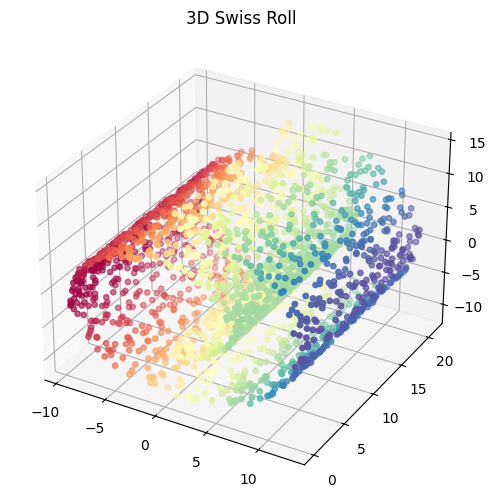

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

# Generate Swiss Roll dataset with 2500 samples
n_samples = 2500
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.05)

# Plot the dataset in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 0], cmap='Spectral', s=15)
ax.set_title("3D Swiss Roll")
plt.show()


In [6]:
import torch
import torch.nn as nn

# Define Encoder: 3D -> 2D
class Encoder(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2, hidden_dim=128):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

# Define Decoder: 2D -> 3D
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, output_dim=3, hidden_dim=128):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, z):
        return self.net(z)

# Combine to form the Auto-Encoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2, hidden_dim=128):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, input_dim, hidden_dim)
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Initialize the model
model = AutoEncoder(input_dim=3, latent_dim=2, hidden_dim=128)
print(model)


AutoEncoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=3, bias=True)
    )
  )
)


In [7]:
def sliced_wasserstein_distance(z, z_prior, L=512, p=2, eps=1e-8):
    """
    Compute the sliced Wasserstein distance between two sets of latent codes.
    z, z_prior: tensors of shape [N, latent_dim]
    L: number of random projections (slices)
    """
    N, d = z.shape
    # Generate L random unit vectors in R^d
    theta = torch.randn(L, d, device=z.device)
    theta = theta / (theta.norm(dim=1, keepdim=True) + eps)
    
    # Project latent codes onto these directions: shape [N, L]
    proj_z = z @ theta.t()
    proj_z_prior = z_prior @ theta.t()
    
    # Sort the projections along the batch dimension
    proj_z_sorted, _ = torch.sort(proj_z, dim=0)
    proj_z_prior_sorted, _ = torch.sort(proj_z_prior, dim=0)
    
    # Compute the L_p distance between sorted projections and average over slices
    sw_distance = torch.mean(torch.abs(proj_z_sorted - proj_z_prior_sorted) ** p) ** (1.0 / p)
    return sw_distance
# ----- Verification for Sliced-Wasserstein Distance Function -----
import torch

# Create two random latent code tensors:
# Let's assume a latent space of dimension 2 and use 100 samples for testing.
N_test = 100
latent_dim = 2

# Random latent codes (simulate encoded outputs)
z_test = torch.randn(N_test, latent_dim)
# Random latent codes sampled from the standard normal (prior)
z_prior_test = torch.randn(N_test, latent_dim)

# Compute the sliced Wasserstein distance with L = 512 slices
sw_distance_test = sliced_wasserstein_distance(z_test, z_prior_test, L=512, p=2)
print("Sliced Wasserstein Distance (test):", sw_distance_test.item())

# -- Additional sanity checks --
# 1. Check that the output is a scalar.
assert sw_distance_test.dim() == 0, "SWD output should be a scalar."

# 2. Try with identical inputs: SW distance should be near 0.
sw_distance_same = sliced_wasserstein_distance(z_test, z_test, L=512, p=2)
print("Sliced Wasserstein Distance (identical inputs):", sw_distance_same.item())
assert sw_distance_same.item() < 1e-6, "SWD should be near zero for identical inputs."


Sliced Wasserstein Distance (test): 0.2267124056816101
Sliced Wasserstein Distance (identical inputs): 0.0


In [8]:
def loss_function(x, x_recon, z, L=512, lam=1.0):
    # Reconstruction loss: MSE
    recon_loss = torch.mean((x - x_recon) ** 2)
    
    # Sample from the prior (standard normal)
    N = z.shape[0]
    latent_dim = z.shape[1]
    z_prior = torch.randn(N, latent_dim, device=z.device)
    
    # Compute sliced Wasserstein loss
    sw_loss = sliced_wasserstein_distance(z, z_prior, L=L, p=2)
    
    return recon_loss, sw_loss


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # Ensure our data is on the correct device

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
L_slices = 512

recon_losses = []
sw_losses = []

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x_recon, z = model(X_tensor)
    recon_loss, sw_loss = loss_function(X_tensor, x_recon, z, L=L_slices, lam=1.0)
    total_loss = recon_loss + sw_loss
    total_loss.backward()
    optimizer.step()
    
    recon_losses.append(recon_loss.item())
    sw_losses.append(sw_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]: Recon Loss = {recon_loss.item():.4f}, SW Loss = {sw_loss.item():.4f}")


Epoch [20/200]: Recon Loss = 31.9568, SW Loss = 6.8621
Epoch [40/200]: Recon Loss = 17.9791, SW Loss = 7.6561
Epoch [60/200]: Recon Loss = 14.2030, SW Loss = 6.8720
Epoch [80/200]: Recon Loss = 13.5563, SW Loss = 5.8134
Epoch [100/200]: Recon Loss = 12.9461, SW Loss = 5.3114
Epoch [120/200]: Recon Loss = 12.4722, SW Loss = 4.6811
Epoch [140/200]: Recon Loss = 11.9593, SW Loss = 4.2384
Epoch [160/200]: Recon Loss = 11.3210, SW Loss = 3.7948
Epoch [180/200]: Recon Loss = 10.5850, SW Loss = 3.4771
Epoch [200/200]: Recon Loss = 9.9386, SW Loss = 3.1683


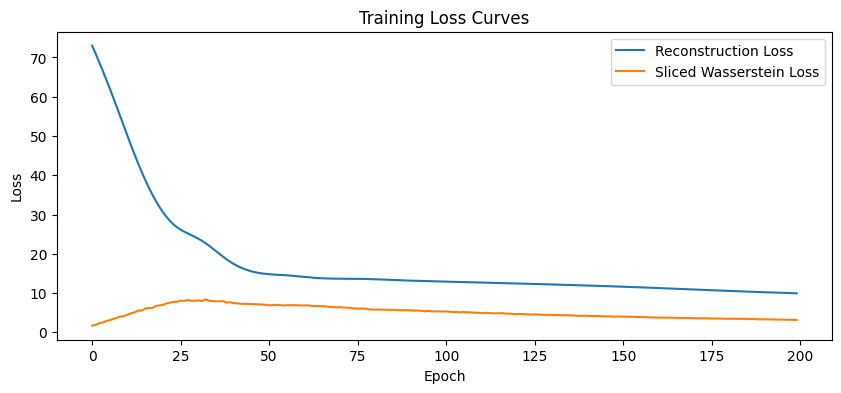

([72.9965591430664, 70.9436264038086, 68.81851959228516, 66.63005065917969, 64.38062286376953, 62.067203521728516, 59.693607330322266, 57.27726364135742, 54.836788177490234, 52.392154693603516, 49.964542388916016, 47.57673263549805, 45.2496452331543, 43.002376556396484, 40.852569580078125, 38.813602447509766, 36.89754867553711, 35.1117057800293, 33.46234130859375, 31.956809997558594, 30.60121726989746, 29.402759552001953, 28.36554527282715, 27.486722946166992, 26.754560470581055, 26.14822769165039, 25.637584686279297, 25.187334060668945, 24.760162353515625, 24.322998046875, 23.84918785095215, 23.320987701416016, 22.731746673583984, 22.084535598754883, 21.393634796142578, 20.677370071411133, 19.958436965942383, 19.25798988342285, 18.593542098999023, 17.979129791259766, 17.422786712646484, 16.928363800048828, 16.496244430541992, 16.12345314025879, 15.805998802185059, 15.539815902709961, 15.320256233215332, 15.14165210723877, 14.999622344970703, 14.888814926147461, 14.804125785827637, 14.

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(sw_losses, label="Sliced Wasserstein Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()
print((recon_losses, sw_losses))

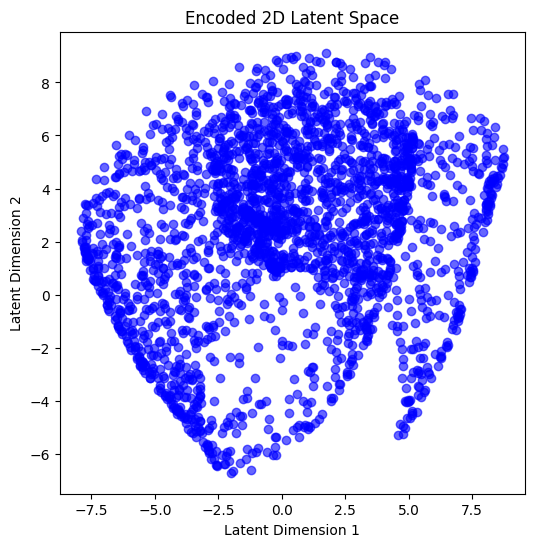

In [12]:
model.eval()
with torch.no_grad():
    _, z = model(X_tensor)
    z = z.cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], c='blue', alpha=0.6)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Encoded 2D Latent Space")
plt.show()


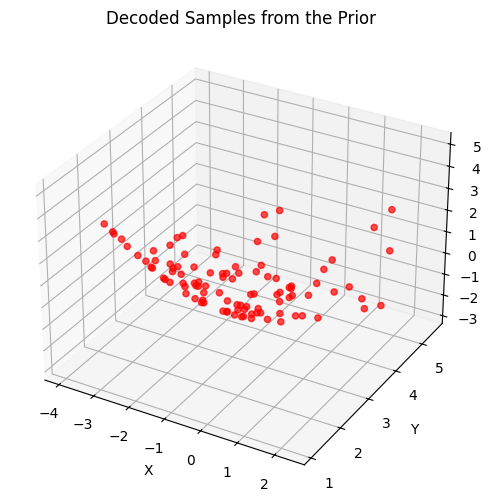

In [13]:
with torch.no_grad():
    # Generate 100 new latent samples from the prior
    z_new = torch.randn(100, latent_dim, device=device)
    x_decoded = model.decoder(z_new)
    x_decoded = x_decoded.cpu().numpy()

# Plot the generated 3D samples
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_decoded[:, 0], x_decoded[:, 1], x_decoded[:, 2], c='red', alpha=0.7)
ax.set_title("Decoded Samples from the Prior")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

# Generate the Swiss Roll dataset with 2500 samples and a bit of noise
n_samples = 2500
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.05)

# Verification: Check shape of the data
print("X shape:", X.shape)  # Expect (2500, 3)


X shape: (2500, 3)


In [19]:
import torch
import torch.nn as nn

# Define the VAE Encoder: maps from 3D to 2D latent space and outputs mu and logvar
class VAEEncoder(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2, hidden_dim=128):
        super(VAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the VAE Decoder: maps from 2D latent space back to 3D
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=2, output_dim=3, hidden_dim=128):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        h = self.relu(self.fc1(z))
        x_recon = self.fc2(h)
        return x_recon

# Combine Encoder and Decoder into the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2, hidden_dim=128):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, latent_dim, hidden_dim)
        self.decoder = VAEDecoder(latent_dim, input_dim, hidden_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # random normal noise
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

# Initialize the VAE model
vae = VAE(input_dim=3, latent_dim=2, hidden_dim=128)
print(vae)


VAE(
  (encoder): VAEEncoder(
    (fc1): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU()
    (fc_mu): Linear(in_features=128, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): VAEDecoder(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [20]:
def vae_loss(x, x_recon, mu, logvar):
    # Reconstruction loss: Mean Squared Error between original and reconstruction
    recon_loss = torch.mean((x - x_recon) ** 2)
    # KL Divergence: Measures how much the learned latent distribution diverges from a Normal prior
    kl_loss = -0.5 * torch.mean(1 + logvar - mu**2 - torch.exp(logvar))
    return recon_loss, kl_loss

# Verification: Test loss function with random inputs
x_sample = torch.randn(10, 3)
x_recon_sample, mu_sample, logvar_sample, _ = vae(x_sample)
recon_loss_val, kl_loss_val = vae_loss(x_sample, x_recon_sample, mu_sample, logvar_sample)
print("Sample Reconstruction Loss:", recon_loss_val.item())
print("Sample KL Divergence Loss:", kl_loss_val.item())


Sample Reconstruction Loss: 1.117427110671997
Sample KL Divergence Loss: 0.02630176767706871


Epoch [20/200]: Recon Loss = 63.0064, KL Loss = 3.7158
Epoch [40/200]: Recon Loss = 26.2713, KL Loss = 13.2492
Epoch [60/200]: Recon Loss = 17.5630, KL Loss = 10.1186
Epoch [80/200]: Recon Loss = 14.8824, KL Loss = 8.2445
Epoch [100/200]: Recon Loss = 13.8243, KL Loss = 6.8490
Epoch [120/200]: Recon Loss = 13.0630, KL Loss = 5.9946
Epoch [140/200]: Recon Loss = 12.2598, KL Loss = 5.3824
Epoch [160/200]: Recon Loss = 11.4712, KL Loss = 4.9340
Epoch [180/200]: Recon Loss = 10.8070, KL Loss = 4.5535
Epoch [200/200]: Recon Loss = 10.2438, KL Loss = 4.2762


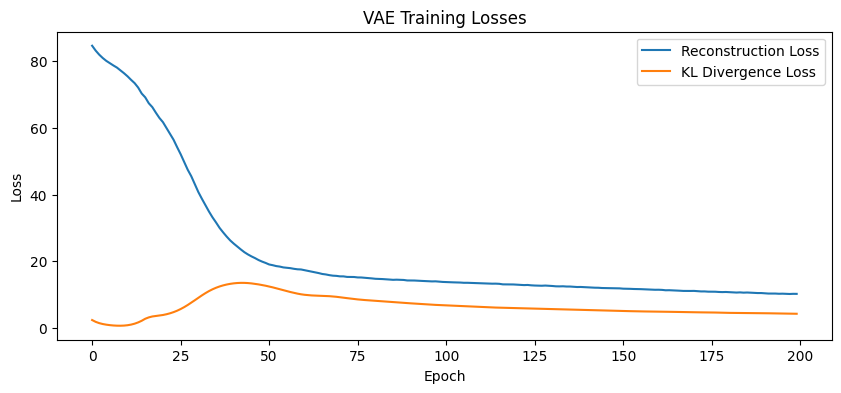

In [21]:
import torch.optim as optim

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

# Convert Swiss Roll data to a PyTorch tensor and send it to the device
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# Optimizer and training parameters
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 200

# Lists to store loss values for plotting
recon_losses = []
kl_losses = []

vae.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x_recon, mu, logvar, z = vae(X_tensor)
    recon_loss, kl_loss = vae_loss(X_tensor, x_recon, mu, logvar)
    total_loss = recon_loss + kl_loss
    total_loss.backward()
    optimizer.step()
    
    recon_losses.append(recon_loss.item())
    kl_losses.append(kl_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]: Recon Loss = {recon_loss.item():.4f}, KL Loss = {kl_loss.item():.4f}")

# Plot training loss curves
plt.figure(figsize=(10, 4))
plt.plot(recon_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Divergence Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Losses")
plt.show()


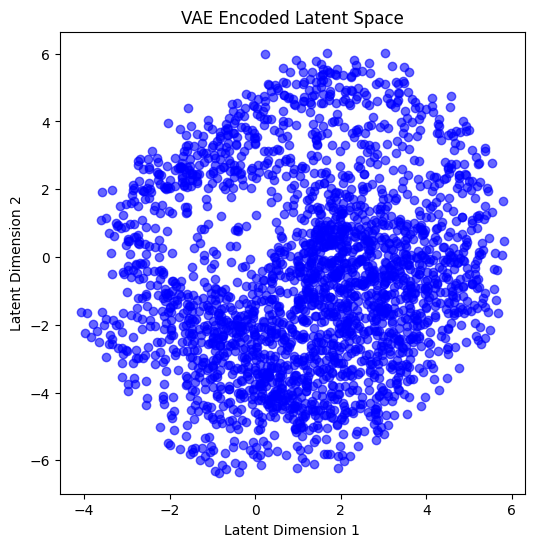

In [22]:
vae.eval()
with torch.no_grad():
    _, mu, logvar, z = vae(X_tensor)
    z = z.cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], c='blue', alpha=0.6)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("VAE Encoded Latent Space")
plt.show()


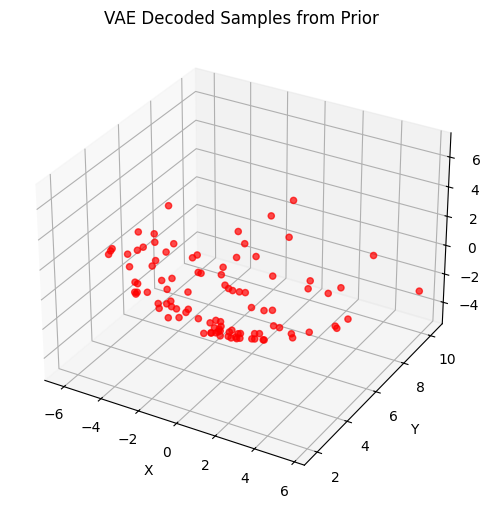

In [23]:
with torch.no_grad():
    # Generate new latent samples from the standard Normal distribution
    z_new = torch.randn(100, 2, device=device)
    x_generated = vae.decoder(z_new)
    x_generated = x_generated.cpu().numpy()

# Plot the generated 3D samples
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_generated[:, 0], x_generated[:, 1], x_generated[:, 2], c='red', alpha=0.7)
ax.set_title("VAE Decoded Samples from Prior")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


SWAE Epoch [20/200]: Recon Loss = 41.8613, SW Loss = 6.5534
SWAE Epoch [40/200]: Recon Loss = 25.1077, SW Loss = 8.7851
SWAE Epoch [60/200]: Recon Loss = 17.8545, SW Loss = 7.4327
SWAE Epoch [80/200]: Recon Loss = 17.0111, SW Loss = 6.5177
SWAE Epoch [100/200]: Recon Loss = 16.1395, SW Loss = 5.9105
SWAE Epoch [120/200]: Recon Loss = 14.9357, SW Loss = 5.2404
SWAE Epoch [140/200]: Recon Loss = 13.9841, SW Loss = 4.6212
SWAE Epoch [160/200]: Recon Loss = 13.4182, SW Loss = 4.1416
SWAE Epoch [180/200]: Recon Loss = 13.0260, SW Loss = 3.7276
SWAE Epoch [200/200]: Recon Loss = 12.7299, SW Loss = 3.3747
VAE Epoch [20/200]: Recon Loss = 58.6065, KL Loss = 5.1869
VAE Epoch [40/200]: Recon Loss = 24.8737, KL Loss = 12.7114
VAE Epoch [60/200]: Recon Loss = 17.0156, KL Loss = 9.1886
VAE Epoch [80/200]: Recon Loss = 14.9382, KL Loss = 7.1973
VAE Epoch [100/200]: Recon Loss = 14.1098, KL Loss = 6.1647
VAE Epoch [120/200]: Recon Loss = 13.6949, KL Loss = 5.4787
VAE Epoch [140/200]: Recon Loss = 13.

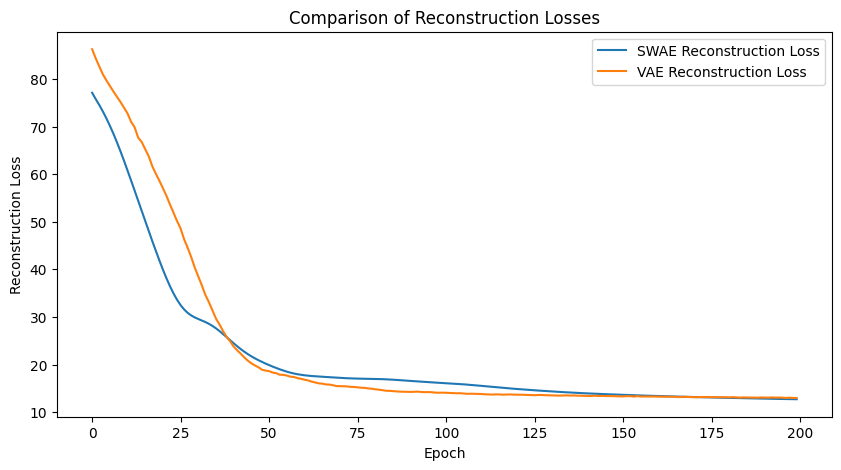

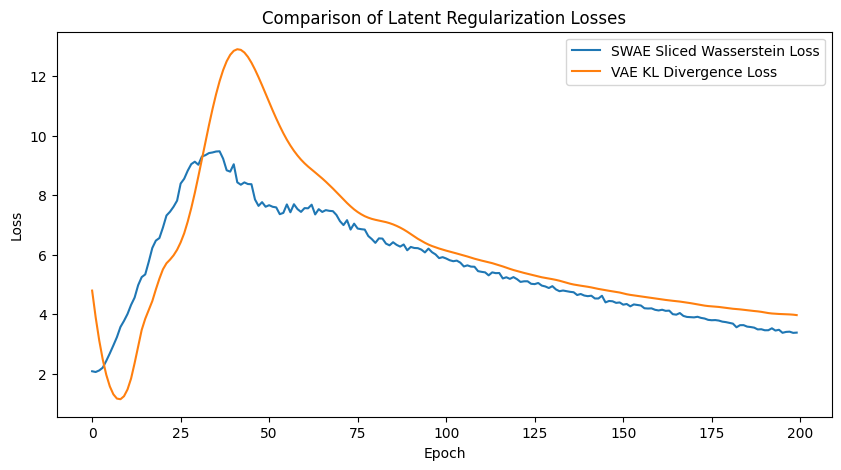

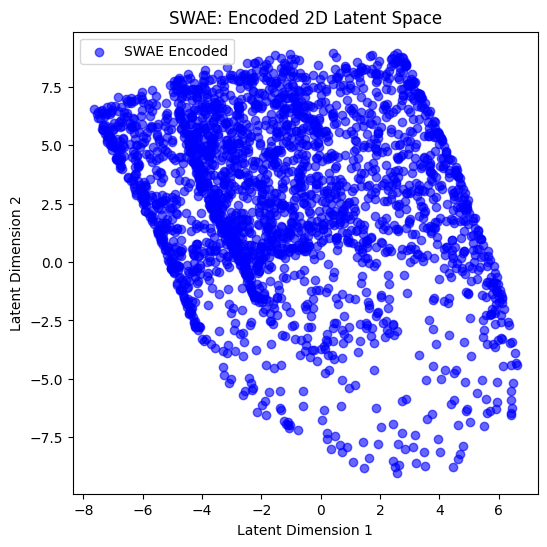

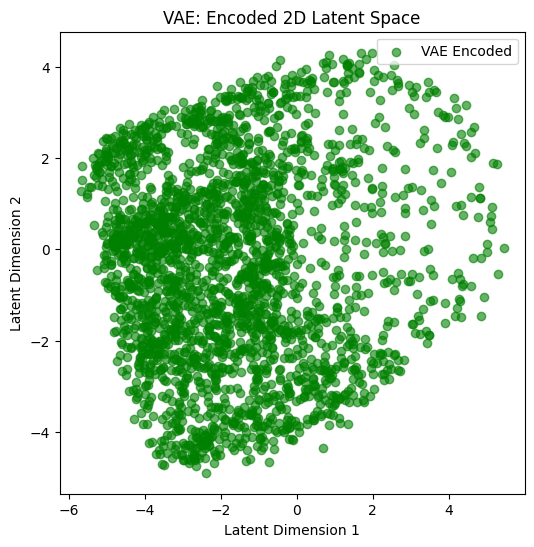

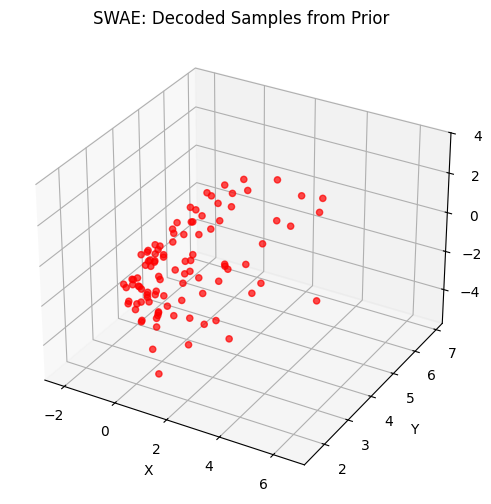

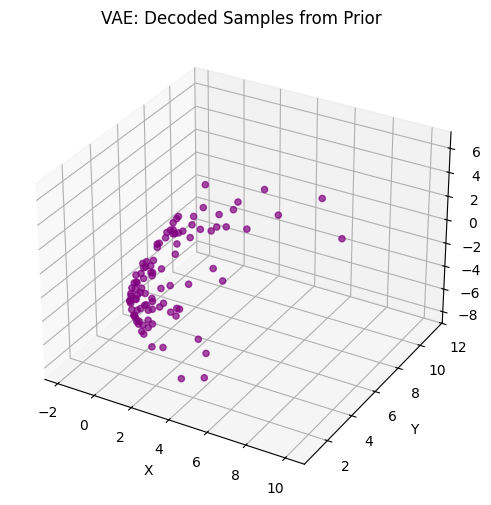

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D
import torch

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate the Swiss Roll dataset
n_samples = 2500
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)

def sliced_wasserstein_distance(z, z_prior, L=512, p=2, eps=1e-8):
    N, d = z.shape
    theta = torch.randn(L, d, device=z.device)
    theta = theta / (theta.norm(dim=1, keepdim=True) + eps)
    proj_z = z @ theta.t()
    proj_z_prior = z_prior @ theta.t()
    proj_z_sorted, _ = torch.sort(proj_z, dim=0)
    proj_z_prior_sorted, _ = torch.sort(proj_z_prior, dim=0)
    sw_distance = torch.mean(torch.abs(proj_z_sorted - proj_z_prior_sorted) ** p) ** (1.0 / p)
    return sw_distance

def swae_loss(x, x_recon, z, L=512):
    # Reconstruction loss (MSE)
    recon_loss = torch.mean((x - x_recon)**2)
    # Sample from Normal prior in latent space
    N = z.shape[0]
    latent_dim = z.shape[1]
    z_prior = torch.randn(N, latent_dim, device=z.device)
    # Sliced-Wasserstein loss
    sw_loss = sliced_wasserstein_distance(z, z_prior, L=L, p=2)
    return recon_loss, sw_loss

# Assume 'model_swae' is our SWAE autoencoder (same architecture as a plain AE)
model_swae = AutoEncoder(input_dim=3, latent_dim=2, hidden_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_swae.to(device)
X_swae = X.to(device)

optimizer_swae = torch.optim.Adam(model_swae.parameters(), lr=1e-3)
num_epochs = 200
L_slices = 512

swae_recon_losses = []
swae_sw_losses = []

model_swae.train()
for epoch in range(num_epochs):
    optimizer_swae.zero_grad()
    x_recon, z = model_swae(X_swae)
    recon_loss, sw_loss = swae_loss(X_swae, x_recon, z, L=L_slices)
    total_loss = recon_loss + sw_loss
    total_loss.backward()
    optimizer_swae.step()
    
    swae_recon_losses.append(recon_loss.item())
    swae_sw_losses.append(sw_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f"SWAE Epoch [{epoch+1}/{num_epochs}]: Recon Loss = {recon_loss.item():.4f}, SW Loss = {sw_loss.item():.4f}")
# Assume VAE model is defined as 'vae' from previous cell.
vae = VAE(input_dim=3, latent_dim=2, hidden_dim=128)
vae.to(device)
X_vae = X.to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)
vae_recon_losses = []
vae_kl_losses = []
num_epochs = 200

vae.train()
for epoch in range(num_epochs):
    optimizer_vae.zero_grad()
    x_recon, mu, logvar, z = vae(X_vae)
    # Compute losses: MSE reconstruction and KL divergence
    recon_loss = torch.mean((X_vae - x_recon)**2)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu**2 - torch.exp(logvar))
    total_loss = recon_loss + kl_loss
    total_loss.backward()
    optimizer_vae.step()
    
    vae_recon_losses.append(recon_loss.item())
    vae_kl_losses.append(kl_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f"VAE Epoch [{epoch+1}/{num_epochs}]: Recon Loss = {recon_loss.item():.4f}, KL Loss = {kl_loss.item():.4f}")
plt.figure(figsize=(10, 5))
plt.plot(swae_recon_losses, label="SWAE Reconstruction Loss")
plt.plot(vae_recon_losses, label="VAE Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.legend()
plt.title("Comparison of Reconstruction Losses")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(swae_sw_losses, label="SWAE Sliced Wasserstein Loss")
plt.plot(vae_kl_losses, label="VAE KL Divergence Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison of Latent Regularization Losses")
plt.show()

# SWAE latent space visualization
model_swae.eval()
with torch.no_grad():
    _, z_swae = model_swae(X_swae)
    z_swae = z_swae.cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(z_swae[:, 0], z_swae[:, 1], c='blue', alpha=0.6, label="SWAE Encoded")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("SWAE: Encoded 2D Latent Space")
plt.legend()
plt.show()

# VAE latent space visualization
vae.eval()
with torch.no_grad():
    _, _, _, z_vae = vae(X_vae)
    z_vae = z_vae.cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(z_vae[:, 0], z_vae[:, 1], c='green', alpha=0.6, label="VAE Encoded")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("VAE: Encoded 2D Latent Space")
plt.legend()
plt.show()

# SWAE: Generate new samples from prior and decode
with torch.no_grad():
    z_new_swae = torch.randn(100, 2, device=device)
    x_decoded_swae = model_swae.decoder(z_new_swae)
    x_decoded_swae = x_decoded_swae.cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_decoded_swae[:, 0], x_decoded_swae[:, 1], x_decoded_swae[:, 2], c='red', alpha=0.7)
ax.set_title("SWAE: Decoded Samples from Prior")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# VAE: Generate new samples from prior and decode
with torch.no_grad():
    z_new_vae = torch.randn(100, 2, device=device)
    x_decoded_vae = vae.decoder(z_new_vae)
    x_decoded_vae = x_decoded_vae.cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_decoded_vae[:, 0], x_decoded_vae[:, 1], x_decoded_vae[:, 2], c='purple', alpha=0.7)
ax.set_title("VAE: Decoded Samples from Prior")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


### Problem 2

Swiss Roll data shape: torch.Size([2500, 3])
Epoch [200/2000] - G_loss: 0.7763, D_loss: 1.2751
Epoch [400/2000] - G_loss: 0.7073, D_loss: 1.2783
Epoch [600/2000] - G_loss: 0.7477, D_loss: 1.3271
Epoch [800/2000] - G_loss: 0.6839, D_loss: 1.3283
Epoch [1000/2000] - G_loss: 0.7767, D_loss: 1.3118
Epoch [1200/2000] - G_loss: 0.7394, D_loss: 1.3447
Epoch [1400/2000] - G_loss: 0.7498, D_loss: 1.3163
Epoch [1600/2000] - G_loss: 0.8576, D_loss: 1.3520
Epoch [1800/2000] - G_loss: 0.8261, D_loss: 1.2944
Epoch [2000/2000] - G_loss: 0.8024, D_loss: 1.3435


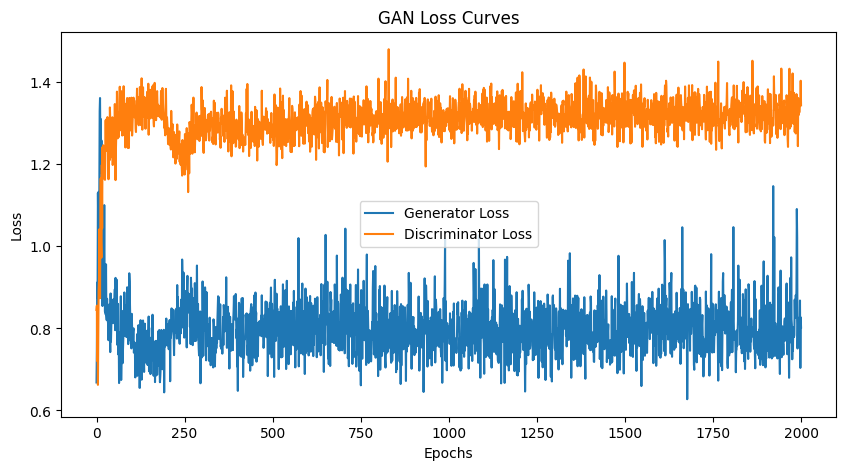

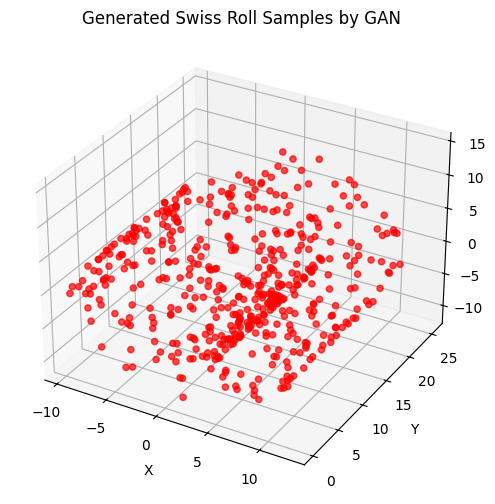

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ----- Step 1: Generate the 3D Swiss Roll Dataset -----
n_samples = 2500
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)
print("Swiss Roll data shape:", X.shape)  # Expected: (2500, 3)


# ----- Step 2: Define the GAN Model -----

# Generator: maps from 2D latent space to 3D output
class Generator(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=128, output_dim=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, z):
        return self.net(z)

# Discriminator: maps from 3D input to a scalar probability (real/fake)
class Discriminator(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(latent_dim=latent_dim, hidden_dim=128, output_dim=3).to(device)
D = Discriminator(input_dim=3, hidden_dim=128).to(device)

# Loss function for GAN (Binary Cross-Entropy)
criterion = nn.BCELoss()

# Optimizers for generator and discriminator
lr = 0.0002
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# ----- Step 3: GAN Training Loop -----
num_epochs = 2000
batch_size = 64
n_batches = n_samples // batch_size

# Containers to store losses
G_losses = []
D_losses = []

X = X.to(device)  # Move data to device

for epoch in range(num_epochs):
    for i in range(n_batches):
        # Sample a random mini-batch of real data
        idx = np.random.randint(0, n_samples, batch_size)
        real_data = X[idx]
        
        # Labels for real (1) and fake (0) data
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        
        # Discriminator on real data
        output_real = D(real_data)
        loss_real = criterion(output_real, real_labels)
        
        # Generate fake data from random latent vectors
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = G(z)
        output_fake = D(fake_data.detach())  # detach to avoid updating G during D's training
        loss_fake = criterion(output_fake, fake_labels)
        
        # Total discriminator loss and update
        D_loss = loss_real + loss_fake
        D_loss.backward()
        optimizer_D.step()
        
        # ---- Train Generator ----
        optimizer_G.zero_grad()
        
        # Generate fake data again
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = G(z)
        output = D(fake_data)
        # Generator aims to fool the discriminator (target = 1)
        G_loss = criterion(output, real_labels)
        G_loss.backward()
        optimizer_G.step()
        
    # Record losses for each epoch (use last mini-batch losses)
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())
    
    if (epoch+1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - G_loss: {G_loss.item():.4f}, D_loss: {D_loss.item():.4f}")

# ----- Step 4: Plot Generator and Discriminator Losses -----
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")
plt.show()

# ----- Step 5: Generate Samples from the Prior and Visualize -----
with torch.no_grad():
    # Sample 500 latent vectors from the 2D Normal prior
    z_new = torch.randn(500, latent_dim, device=device)
    fake_samples = G(z_new).cpu().numpy()

# Plot the generated samples in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fake_samples[:, 0], fake_samples[:, 1], fake_samples[:, 2], c='red', alpha=0.7)
ax.set_title("Generated Swiss Roll Samples by GAN")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


Swiss Roll data shape: torch.Size([2500, 3])
Epoch [200/2000] - Generator SW Loss: 1.6602
Epoch [400/2000] - Generator SW Loss: 1.6859
Epoch [600/2000] - Generator SW Loss: 1.7250
Epoch [800/2000] - Generator SW Loss: 1.7383
Epoch [1000/2000] - Generator SW Loss: 1.7084
Epoch [1200/2000] - Generator SW Loss: 1.6092
Epoch [1400/2000] - Generator SW Loss: 1.7567
Epoch [1600/2000] - Generator SW Loss: 1.6529
Epoch [1800/2000] - Generator SW Loss: 1.6271
Epoch [2000/2000] - Generator SW Loss: 1.7015


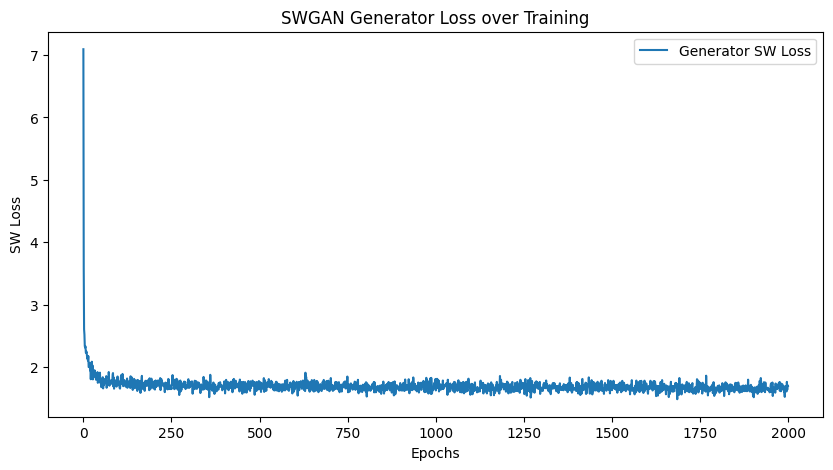

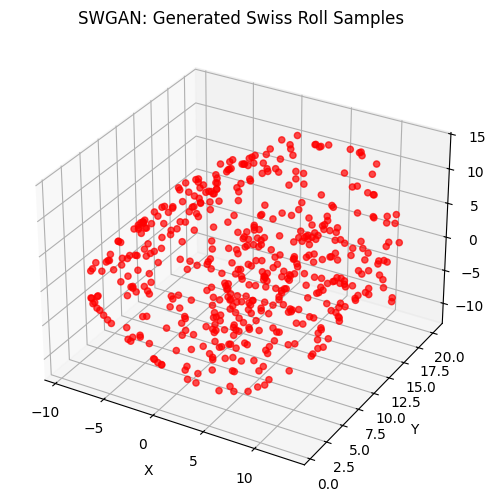

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ----- Step 1: Generate the 3D Swiss Roll Dataset -----
n_samples = 2500
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)
print("Swiss Roll data shape:", X.shape)  # Expected: (2500, 3)


# ----- Step 2: Define the Generator Model -----
# Generator: maps from a 2D latent space to a 3D output.
class Generator(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=128, output_dim=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, z):
        return self.net(z)

latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_sw = Generator(latent_dim=latent_dim, hidden_dim=128, output_dim=3).to(device)

# ----- Step 3: Define the Sliced-Wasserstein Distance Function -----
def sliced_wasserstein_distance(x, y, L=512, p=2, eps=1e-8):
    """
    Compute the Sliced Wasserstein Distance between two sets of samples.
    x, y: tensors of shape [N, d] (e.g., real and generated samples)
    L: number of random projection slices
    p: L_p norm (p=2 gives Euclidean distance)
    """
    N, d = x.shape
    # Generate L random directions (unit vectors) in R^d
    theta = torch.randn(L, d, device=x.device)
    theta = theta / (theta.norm(dim=1, keepdim=True) + eps)
    
    # Project x and y onto these directions: result shape [N, L]
    proj_x = x @ theta.t()
    proj_y = y @ theta.t()
    
    # Sort the projections along the sample dimension
    proj_x_sorted, _ = torch.sort(proj_x, dim=0)
    proj_y_sorted, _ = torch.sort(proj_y, dim=0)
    
    # Compute the average L_p distance between sorted projections
    sw_distance = torch.mean(torch.abs(proj_x_sorted - proj_y_sorted) ** p) ** (1.0 / p)
    return sw_distance

# ----- Step 4: Training Loop for the Sliced-Wasserstein GAN -----
# Here, we train the generator to minimize the SW distance between a mini-batch of real data
# and generated data.

optimizer_G_sw = optim.Adam(G_sw.parameters(), lr=0.001)
num_epochs = 2000
batch_size = 64
n_batches = n_samples // batch_size
G_sw_losses = []

X = X.to(device)  # Move Swiss Roll data to the device

for epoch in range(num_epochs):
    epoch_loss = 0
    for i in range(n_batches):
        # Sample a mini-batch of real data
        idx = np.random.randint(0, n_samples, batch_size)
        real_batch = X[idx]
        
        # Sample latent vectors from 2D Normal prior
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_batch = G_sw(z)
        
        # Compute the Sliced Wasserstein loss between real and fake samples
        loss = sliced_wasserstein_distance(real_batch, fake_batch, L=512, p=2)
        
        optimizer_G_sw.zero_grad()
        loss.backward()
        optimizer_G_sw.step()
        
        epoch_loss += loss.item()
    avg_loss = epoch_loss / n_batches
    G_sw_losses.append(avg_loss)
    if (epoch+1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Generator SW Loss: {avg_loss:.4f}")

# ----- Step 5: Plot Generator Loss Curve -----
plt.figure(figsize=(10, 5))
plt.plot(G_sw_losses, label="Generator SW Loss")
plt.xlabel("Epochs")
plt.ylabel("SW Loss")
plt.legend()
plt.title("SWGAN Generator Loss over Training")
plt.show()

# ----- Step 6: Generate Samples and Visualize the Generated Swiss Roll -----
with torch.no_grad():
    # Sample 500 latent vectors from the prior distribution
    z_new = torch.randn(500, latent_dim, device=device)
    fake_samples = G_sw(z_new).cpu().numpy()

# Plot the generated 3D samples
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fake_samples[:, 0], fake_samples[:, 1], fake_samples[:, 2], c='red', alpha=0.7)
ax.set_title("SWGAN: Generated Swiss Roll Samples")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


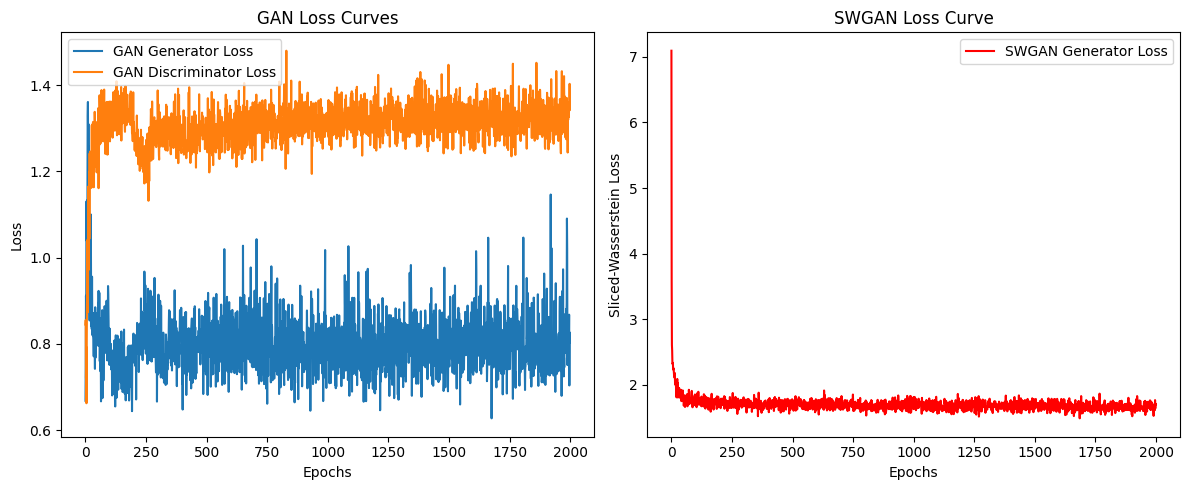

In [4]:
plt.figure(figsize=(12, 5))

# GAN Loss Curves
plt.subplot(1, 2, 1)
plt.plot(G_losses, label="GAN Generator Loss")
plt.plot(D_losses, label="GAN Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")

# SWGAN Loss Curve
plt.subplot(1, 2, 2)
plt.plot(G_sw_losses, label="SWGAN Generator Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Sliced-Wasserstein Loss")
plt.legend()
plt.title("SWGAN Loss Curve")

plt.tight_layout()
plt.show()


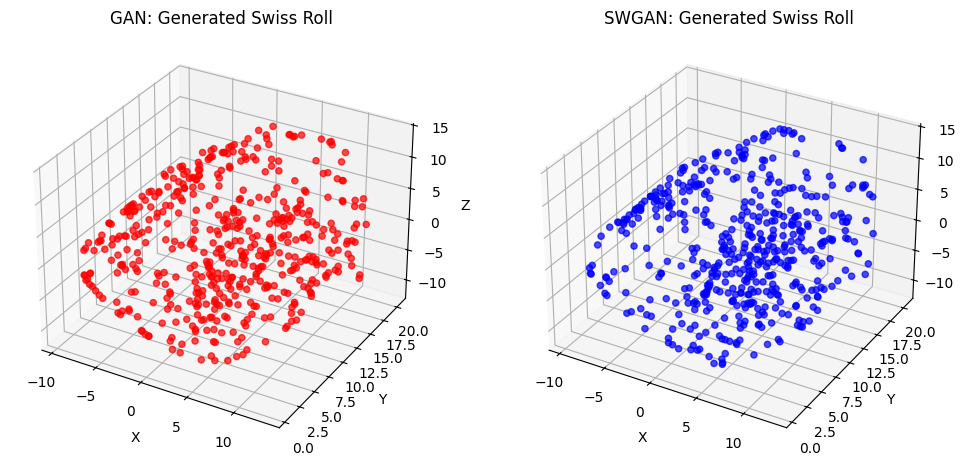

In [5]:
fig = plt.figure(figsize=(12, 6))

# GAN Samples
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(fake_samples[:, 0], fake_samples[:, 1], fake_samples[:, 2], c='red', alpha=0.7)
ax1.set_title("GAN: Generated Swiss Roll")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# SWGAN Samples
with torch.no_grad():
    z_new = torch.randn(500, latent_dim, device=device)
    fake_samples_sw = G_sw(z_new).cpu().numpy()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(fake_samples_sw[:, 0], fake_samples_sw[:, 1], fake_samples_sw[:, 2], c='blue', alpha=0.7)
ax2.set_title("SWGAN: Generated Swiss Roll")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.show()


### Problem 3

Epoch 0, Loss: 1.0466724634170532
Epoch 500, Loss: 0.28091517090797424
Epoch 1000, Loss: 0.29855382442474365
Epoch 1500, Loss: 0.268688440322876
Epoch 2000, Loss: 0.27922460436820984
Epoch 2500, Loss: 0.26104646921157837
Epoch 3000, Loss: 0.2628858983516693
Epoch 3500, Loss: 0.28721678256988525
Epoch 4000, Loss: 0.24934180080890656
Epoch 4500, Loss: 0.2837599217891693


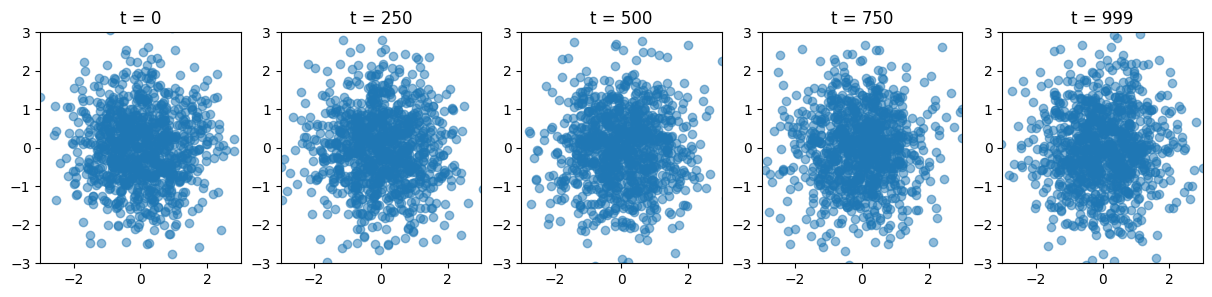

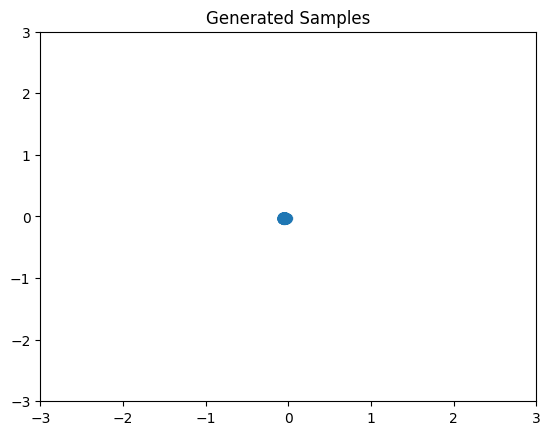

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Sinusoidal Embedding
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, dtype=torch.float32))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

# 2. Noise Predictor Network
class NoisePredictor(nn.Module):
    def __init__(self, input_dim: int = 3, time_emb_dim: int = 128, hidden_dim: int = 512):
        super().__init__()
        self.time_embedding = SinusoidalEmbedding(time_emb_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        x_input = torch.cat([x, t_emb], dim=-1)
        return self.net(x_input)
def forward_diffusion(x_0, t, beta):
    noise = torch.randn_like(x_0)
    sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1 - beta, dim=0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - torch.cumprod(1 - beta, dim=0))
    
    # Ensure t is a 1D tensor
    if t.dim() == 0:
        t = t.unsqueeze(0)
    
    # Index and reshape to match x_0's shape
    sqrt_alpha_cumprod_t = sqrt_alpha_cumprod[t].view(-1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod[t].view(-1, 1)
    
    x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
    return x_t, noise


# 4. Training the Noise Predictor
def train_noise_predictor(model, data, epochs=5000, timesteps=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    beta = torch.linspace(0.0001, 0.02, timesteps)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        t = torch.randint(0, timesteps, (data.size(0),), device=data.device)
        x_t, noise = forward_diffusion(data, t, beta)
        pred_noise = model(x_t, t.float())
        loss = loss_fn(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

# 5. Reverse Diffusion Process
def reverse_diffusion(model, num_samples, timesteps=1000):
    beta = torch.linspace(0.0001, 0.02, timesteps)
    sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1 - beta, dim=0))
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - torch.cumprod(1 - beta, dim=0))
    x_t = torch.randn(num_samples, 3)

    for t in reversed(range(timesteps)):
        t_tensor = torch.full((num_samples,), t, dtype=torch.float32)
        pred_noise = model(x_t, t_tensor)
        x_t = (x_t - beta[t] * pred_noise) / torch.sqrt(1 - beta[t])

    return x_t

# 6. Visualization
def visualize_diffusion(data, model, timesteps=1000):
    beta = torch.linspace(0.0001, 0.02, timesteps)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i, t in enumerate([0, timesteps // 4, timesteps // 2, 3 * timesteps // 4, timesteps - 1]):
        x_t, _ = forward_diffusion(data, torch.tensor([t]), beta)
        axes[i].scatter(x_t[:, 0].cpu(), x_t[:, 1].cpu(), alpha=0.5)
        axes[i].set_title(f't = {t}')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)

    plt.show()

    generated_samples = reverse_diffusion(model, num_samples=data.size(0), timesteps=timesteps)
    plt.scatter(generated_samples[:, 0].cpu().detach().numpy(), generated_samples[:, 1].cpu().detach().numpy(), alpha=0.5)

    plt.title('Generated Samples')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Generate synthetic data
    data = torch.randn(1000, 3)

    # Initialize and train the noise predictor
    noise_predictor = NoisePredictor()
    noise_predictor = train_noise_predictor(noise_predictor, data)

    # Visualize the diffusion processes
    visualize_diffusion(data, noise_predictor)


Epoch 0, Loss: 0.972715
Epoch 500, Loss: 0.264461
Epoch 1000, Loss: 0.265306
Epoch 1500, Loss: 0.316260
Epoch 2000, Loss: 0.285539
Epoch 2500, Loss: 0.269409
Epoch 3000, Loss: 0.298615
Epoch 3500, Loss: 0.259569
Epoch 4000, Loss: 0.302048
Epoch 4500, Loss: 0.278149


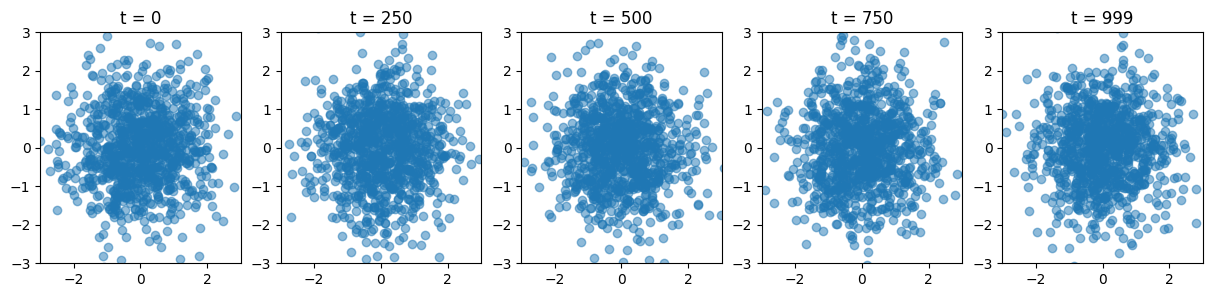

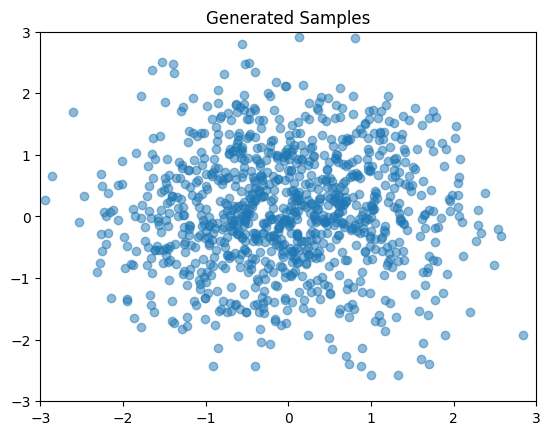

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Sinusoidal Time Embedding
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, dtype=torch.float32))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

# 2. Noise Predictor Network (MLP)
class NoisePredictor(nn.Module):
    def __init__(self, input_dim: int = 3, time_emb_dim: int = 128, hidden_dim: int = 512):
        super().__init__()
        self.time_embedding = SinusoidalEmbedding(time_emb_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        x_input = torch.cat([x, t_emb], dim=-1)
        return self.net(x_input)

# 3. Forward Diffusion Process
def forward_diffusion(x_0, t, beta):
    noise = torch.randn_like(x_0)
    
    # Compute cumulative product of alpha_t
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    # Ensure t is within range
    t = torch.clamp(t, 0, len(alpha_bar) - 1)
    
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(-1, 1)
    
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

# 4. Training the Noise Predictor
def train_noise_predictor(model, data, epochs=5000, timesteps=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    beta = torch.linspace(0.0001, 0.02, timesteps)  # Linear schedule for β_t
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        t = torch.randint(0, timesteps, (data.size(0),), device=data.device)
        x_t, noise = forward_diffusion(data, t, beta)
        pred_noise = model(x_t, t.float())
        loss = loss_fn(pred_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

    return model

# 5. Reverse Diffusion Process (Sampling)
def reverse_diffusion(model, num_samples, timesteps=1000):
    beta = torch.linspace(0.0001, 0.02, timesteps)  
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    
    x_t = torch.randn(num_samples, 3)  # Start from Gaussian noise

    for t in reversed(range(1, timesteps)):  # Iterate backward in time
        t_tensor = torch.full((num_samples,), t, dtype=torch.float32)
        pred_noise = model(x_t, t_tensor)
        
        # Compute reverse step
        alpha_t = alpha[t]
        alpha_bar_t = alpha_bar[t]
        alpha_bar_t_prev = alpha_bar[t - 1] if t > 0 else torch.tensor(1.0)

        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * pred_noise)
        if t > 1:
            noise = torch.randn_like(x_t)
            std = torch.sqrt((1 - alpha_bar_t_prev) / (1 - alpha_bar_t) * beta[t])
            x_t = mean + std * noise
        else:
            x_t = mean  # No noise at t=1

    return x_t

# 6. Visualization of the Diffusion Process
def visualize_diffusion(data, model, timesteps=1000):
    beta = torch.linspace(0.0001, 0.02, timesteps)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i, t in enumerate([0, timesteps // 4, timesteps // 2, 3 * timesteps // 4, timesteps - 1]):
        x_t, _ = forward_diffusion(data, torch.tensor([t]), beta)
        axes[i].scatter(x_t[:, 0].cpu(), x_t[:, 1].cpu(), alpha=0.5)
        axes[i].set_title(f't = {t}')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)

    plt.show()

    generated_samples = reverse_diffusion(model, num_samples=data.size(0), timesteps=timesteps)
    plt.scatter(generated_samples[:, 0].cpu().detach().numpy(), 
                generated_samples[:, 1].cpu().detach().numpy(), alpha=0.5)

    plt.title('Generated Samples')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()

# 7. Running the Full Pipeline
if __name__ == "__main__":
    torch.manual_seed(42)  # Set seed for reproducibility
    
    # Generate synthetic data (Swiss roll or Gaussian mixture)
    data = torch.randn(1000, 3)

    # Initialize and train the noise predictor
    noise_predictor = NoisePredictor()
    noise_predictor = train_noise_predictor(noise_predictor, data)

    # Visualize the diffusion processes
    visualize_diffusion(data, noise_predictor)
